In [121]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt

1. [Pre-processing](#pre-processing)
2. [Trend estimation](#trend-estimation)
   1. [Fitting the linear trend](#fitting-the-linear-trend)
   2. [Fitting the quadratic trend](#fitting-the-quadratic-trend)
   3. [Fitting the qubic trend](#fitting-the-qubic-trend)
   4. [Comparison](#comparison)
3. [ACF analysis of a residual](#acf-analysis-of-a-residual)
4. [Seasonality](#seasonality)
5. [Final decomposition and results](#final-decomposition-and-results)
   1. [Looking at predictions](#looking-at-predictions)
   2. [Range of values](#range-of-values)
   3. [Stationarity of a residual](#stationarity-of-a-residual)

## Pre-processing

In [122]:
co2_data = pd.read_csv('data/CO2.csv', skiprows=54)
co2_data

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally
0,,,,,,adjusted,,adjusted fit,filled,adjusted filled
1,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm]
2,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
3,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
4,1958,03,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
...,...,...,...,...,...,...,...,...,...,...
741,2019,08,43692,2019.6219,410.08,411.62,410.17,411.75,410.08,411.62
742,2019,09,43723,2019.7068,408.55,412.06,-99.99,-99.99,408.55,412.06
743,2019,10,43753,2019.7890,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
744,2019,11,43784,2019.8740,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99


We must concatenate the first three rows and put them as new column names. 

In [123]:
co2_data.columns += ' ' + co2_data.iloc[0].str.strip() + ' ' + co2_data.iloc[1].str.strip()
co2_data.columns = co2_data.columns.str.strip().str.replace(r'\s+', ' ', regex=True)
co2_data = co2_data.iloc[2:].reset_index(drop=True)
co2_data

,Yr,Mn,Date Excel,Date,CO2 [ppm],seasonally adjusted [ppm],fit [ppm],seasonally adjusted fit [ppm],CO2 filled [ppm],seasonally adjusted filled [ppm]
0,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
2,1958,03,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
3,1958,04,21290,1958.2877,317.45,315.16,317.30,314.98,317.45,315.16
4,1958,05,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71
...,...,...,...,...,...,...,...,...,...,...
739,2019,08,43692,2019.6219,410.08,411.62,410.17,411.75,410.08,411.62
740,2019,09,43723,2019.7068,408.55,412.06,-99.99,-99.99,408.55,412.06
741,2019,10,43753,2019.7890,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
742,2019,11,43784,2019.8740,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99


In [124]:
co2_data['CO2 [ppm]'] = co2_data['CO2 [ppm]'].astype(float)
co2_data['Time'] = (co2_data.index + 0.5) / 12 # calculating the new continuous time based on index

In [173]:
co2_data_filtered = co2_data.loc[co2_data['CO2 [ppm]'] != -99.99][['Yr', 'Mn', 'Time', 'CO2 [ppm]']].reset_index(drop=True)
co2_data_filtered['Date'] = pd.to_datetime(dict(year=co2_data_filtered['Yr'], month=co2_data_filtered['Mn'], day=15))
co2_data_filtered

,Yr,Mn,Time,CO2 [ppm],Date
0,1958,03,0.208333,315.70,1958-03-15
1,1958,04,0.291667,317.45,1958-04-15
2,1958,05,0.375000,317.51,1958-05-15
3,1958,07,0.541667,315.86,1958-07-15
4,1958,08,0.625000,314.93,1958-08-15
...,...,...,...,...,...
729,2019,05,61.375000,414.83,2019-05-15
730,2019,06,61.458333,413.96,2019-06-15
731,2019,07,61.541667,411.85,2019-07-15
732,2019,08,61.625000,410.08,2019-08-15


In [174]:
# train/test split
n_split = int(len(co2_data_filtered) * 0.8)
co2_data_train = co2_data_filtered.iloc[0:n_split].copy()
co2_data_test = co2_data_filtered.iloc[n_split+1:].copy()

In [175]:
train_MAPE = []
test_MAPE = []

## Trend estimation

### Fitting the linear trend

In [176]:
linear_trend = LinearRegression().fit(co2_data_train[['Time']], co2_data_train['CO2 [ppm]'])

In [177]:
alpha0 = linear_trend.intercept_
alpha1 = linear_trend.coef_[0]

In [178]:
print(alpha0, alpha1)

308.9916567323666 1.4066911494215175


In [179]:
train_prediction = linear_trend.predict(co2_data_train[['Time']])
residual1 = co2_data_train['CO2 [ppm]'] - train_prediction

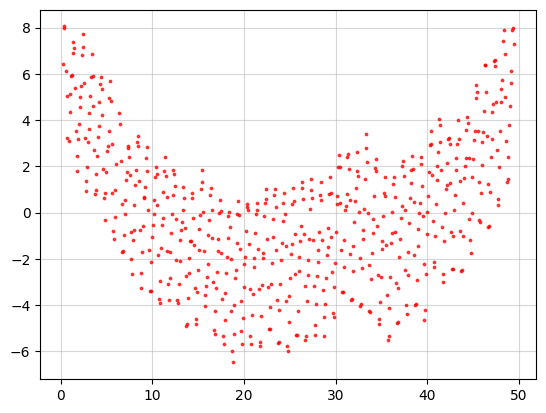

In [180]:
plt.grid(alpha=0.5)
plt.scatter(co2_data_train['Time'], residual1, alpha=0.7, c='red', s=3, zorder=10)

In [181]:
test_prediction = linear_trend.predict(co2_data_test[['Time']])

In [182]:
mean_squared_error(co2_data_test['CO2 [ppm]'], test_prediction, squared=False)

10.667198942482385

In [183]:
train_MAPE.append(mean_absolute_percentage_error(co2_data_train['CO2 [ppm]'], train_prediction))
test_MAPE.append(mean_absolute_percentage_error(co2_data_test['CO2 [ppm]'], test_prediction))

In [184]:
train_MAPE, test_MAPE

([0.00726865748018263], [0.02456979318857693])

### Fitting the quadratic trend

In [185]:
co2_data_train['Time2'] = co2_data_train['Time'] ** 2
co2_data_test['Time2'] = co2_data_test['Time'] ** 2

In [186]:
quadratic_trend = LinearRegression().fit(co2_data_train[['Time', 'Time2']], co2_data_train['CO2 [ppm]'])

In [187]:
beta0 = quadratic_trend.intercept_
beta1 = quadratic_trend.coef_[0]
beta2 = quadratic_trend.coef_[1]
print(beta0, beta1, beta2)

314.1005841870842 0.802097021160315 0.01211749969812116


In [188]:
train_prediction = quadratic_trend.predict(co2_data_train[['Time', 'Time2']])
residual2 = co2_data_train['CO2 [ppm]'] - train_prediction

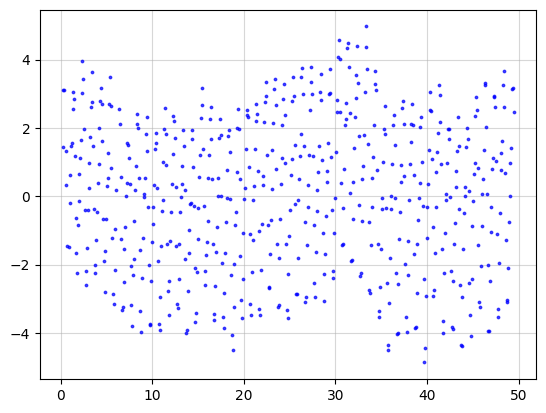

In [189]:
plt.grid(alpha=0.5)
plt.scatter(co2_data_train['Time'], residual2, alpha=0.7, c='blue', s=3, zorder=10)

In [190]:
test_prediction = quadratic_trend.predict(co2_data_test[['Time', 'Time2']])

In [191]:
mean_squared_error(co2_data_test['CO2 [ppm]'], test_prediction, squared=False)

2.5088714286955427

In [192]:
train_MAPE.append(mean_absolute_percentage_error(co2_data_train['CO2 [ppm]'], train_prediction))
test_MAPE.append(mean_absolute_percentage_error(co2_data_test['CO2 [ppm]'], test_prediction))

In [193]:
train_MAPE, test_MAPE

([0.00726865748018263, 0.005370090104113929],
 [0.02456979318857693, 0.0053414147544900885])

### Fitting the qubic trend

In [194]:
co2_data_train['Time3'] = co2_data_train['Time'] ** 3
co2_data_test['Time3'] = co2_data_test['Time'] ** 3

In [195]:
qubic_trend = LinearRegression().fit(co2_data_train[['Time', 'Time2', 'Time3']], co2_data_train['CO2 [ppm]'])

In [196]:
gamma0 = qubic_trend.intercept_
gamma1 = qubic_trend.coef_[0]
gamma2 = qubic_trend.coef_[1]
gamma3 = qubic_trend.coef_[2]
print(gamma0, gamma1, gamma2, gamma3)

314.85852615628914 0.6248954085886236 0.020957567397565654 -0.00011832339739603626


Here, we see that $\gamma_3$ parameter corresponding to the qubic term is relatively small, meaning that we aren't improving much in comparison to the quadratic trend. 

In [197]:
train_prediction = qubic_trend.predict(co2_data_train[['Time', 'Time2', 'Time3']])
residual3 = co2_data_train['CO2 [ppm]'] - train_prediction

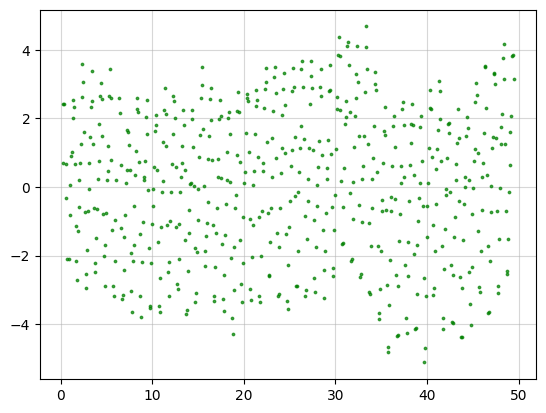

In [198]:
plt.grid(alpha=0.5)
plt.scatter(co2_data_train['Time'], residual3, alpha=0.7, c='green', s=3, zorder=10)

In [199]:
test_prediction = qubic_trend.predict(co2_data_test[['Time', 'Time2', 'Time3']])

In [200]:
mean_squared_error(co2_data_test['CO2 [ppm]'], test_prediction, squared=False)

4.161521563965981

In [201]:
train_MAPE.append(mean_absolute_percentage_error(co2_data_train['CO2 [ppm]'], train_prediction))
test_MAPE.append(mean_absolute_percentage_error(co2_data_test['CO2 [ppm]'], test_prediction))

In [202]:
train_MAPE, test_MAPE

([0.00726865748018263, 0.005370090104113929, 0.005338839730194808],
 [0.02456979318857693, 0.0053414147544900885, 0.008513588199948062])

### Comparison

Text(0.5, 0.98, 'Residuals')

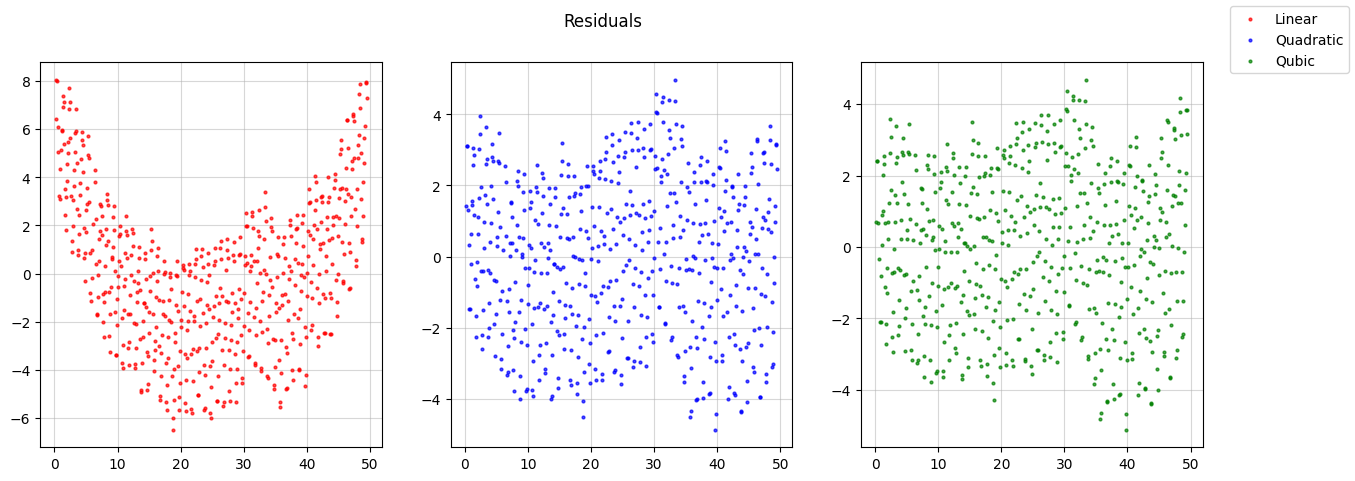

In [203]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].grid(alpha=0.5)
axes[0].scatter(co2_data_train['Time'], residual1, alpha=0.7, c='red', s=4, zorder=10, label='Linear')
axes[1].grid(alpha=0.5)
axes[1].scatter(co2_data_train['Time'], residual2, alpha=0.7, c='blue', s=4, zorder=10, label='Quadratic')
axes[2].grid(alpha=0.5)
axes[2].scatter(co2_data_train['Time'], residual3, alpha=0.7, c='green', s=4, zorder=10, label='Qubic')
fig.legend()
fig.suptitle('Residuals')

In [204]:
MAPE = pd.DataFrame(np.array([train_MAPE, test_MAPE]).transpose() * 100, columns=['Train', 'Test'])
MAPE.loc[0, 'Model'] = 'Linear'
MAPE.loc[1, 'Model'] = 'Quadratic'
MAPE.loc[2, 'Model'] = 'Qubic'

In [205]:
MAPE = MAPE.melt('Model', ['Train', 'Test']).rename(columns={'variable': 'Subset', 'value': 'MAPE %'})

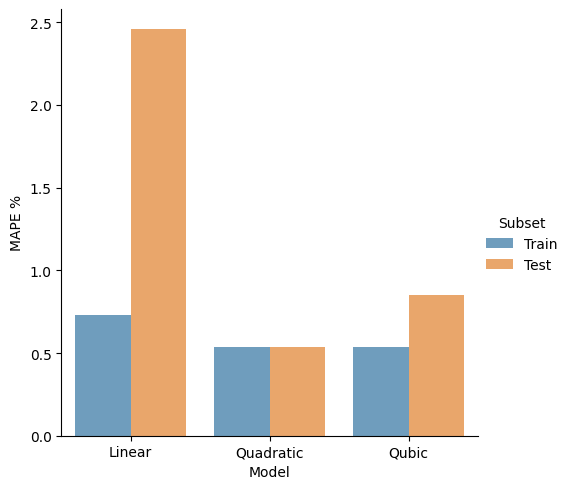

In [206]:
sns.catplot(data=MAPE, kind='bar',
    x='Model', y='MAPE %', hue='Subset', alpha=0.7)

## ACF analysis of a residual

C:\Users\79117\AppData\Local\Temp\ipykernel_12872\2594062836.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


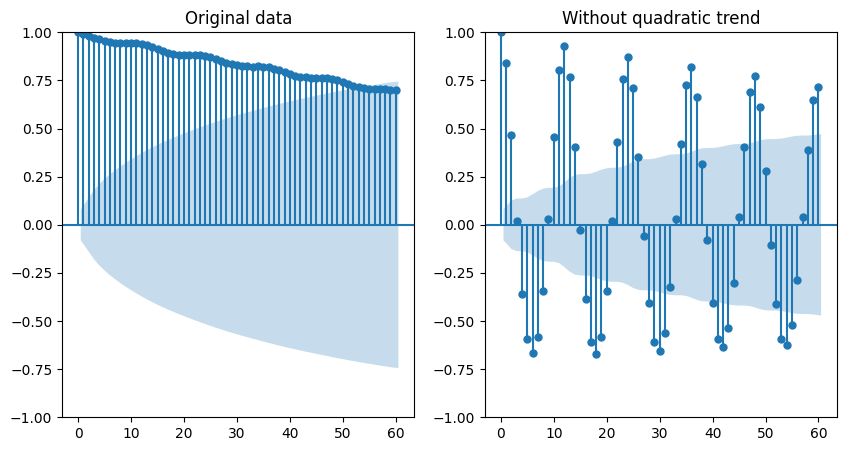

In [207]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sm.graphics.tsa.plot_acf(co2_data_train['CO2 [ppm]'], lags=60, ax=axes[0], title='Original data')
sm.graphics.tsa.plot_acf(residual2, lags=60, ax=axes[1], title='Without quadratic trend')
fig.show()

## Seasonality

In [208]:
co2_data_train['Residual'] = co2_data_train['CO2 [ppm]'] - quadratic_trend.predict(co2_data_train[['Time', 'Time2']])
periodic_part = co2_data_train.groupby('Mn').agg({'Residual': 'mean'}).reset_index().rename(columns={'Residual': 'Periodic'})

In [209]:
# we need this to build a table later
idx_to_month = pd.DataFrame.from_dict({
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
}, orient='index').reset_index().rename(columns={'index': 'Mn', 0: 'Month'})

idx_to_month['Mn'] = idx_to_month['Mn'].astype(str).str.strip()
periodic_part['Mn'] = periodic_part['Mn'].astype(str).str.strip()

In [210]:
periodic_part = pd.merge(periodic_part, idx_to_month, on='Mn')

In [211]:
periodic_part.set_index('Month')

,Mn,Periodic
Month,,
Jan,01,-0.012919
Feb,02,0.646407
Mar,03,1.355569
Apr,04,2.561858
May,05,2.982891
Jun,06,2.316473
Jul,07,0.776297
Aug,08,-1.301213
Sep,09,-3.128074


Text(0, 0.5, 'Average residual')

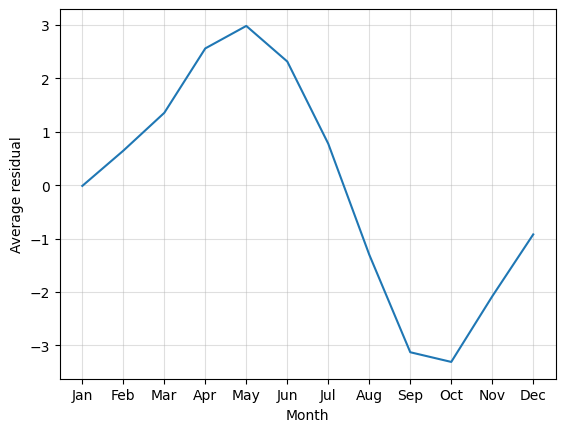

In [212]:
plt.plot(periodic_part['Month'], periodic_part['Periodic'])
plt.grid(alpha=0.4)
plt.xlabel('Month')
plt.ylabel('Average residual')

## Final decomposition and results

### Looking at predictions

In [213]:
co2_data_train['Mn'] = co2_data_train['Mn'].str.strip()
co2_data_test['Mn'] = co2_data_test['Mn'].str.strip()
co2_data_train = pd.merge(co2_data_train, periodic_part, on='Mn')
co2_data_test = pd.merge(co2_data_test, periodic_part, on='Mn')
co2_data_train = co2_data_train.sort_values('Time').reset_index(drop=True)
co2_data_test = co2_data_test.sort_values('Time').reset_index(drop=True)

In [214]:
co2_data_train['Prediction'] = quadratic_trend.predict(co2_data_train[['Time', 'Time2']]) + co2_data_train['Periodic']
co2_data_test['Prediction'] = quadratic_trend.predict(co2_data_test[['Time', 'Time2']]) + co2_data_test['Periodic']

In [215]:
co2_data_filtered['Time2'] = co2_data_filtered['Time'] ** 2
co2_data_filtered['Mn'] = co2_data_filtered['Mn'].str.strip()
co2_data_filtered = pd.merge(co2_data_filtered, periodic_part, on='Mn')
co2_data_filtered['Prediction'] = quadratic_trend.predict(co2_data_filtered[['Time', 'Time2']]) + co2_data_filtered['Periodic']

In [216]:
co2_data_filtered.sort_values('Time', inplace=True)

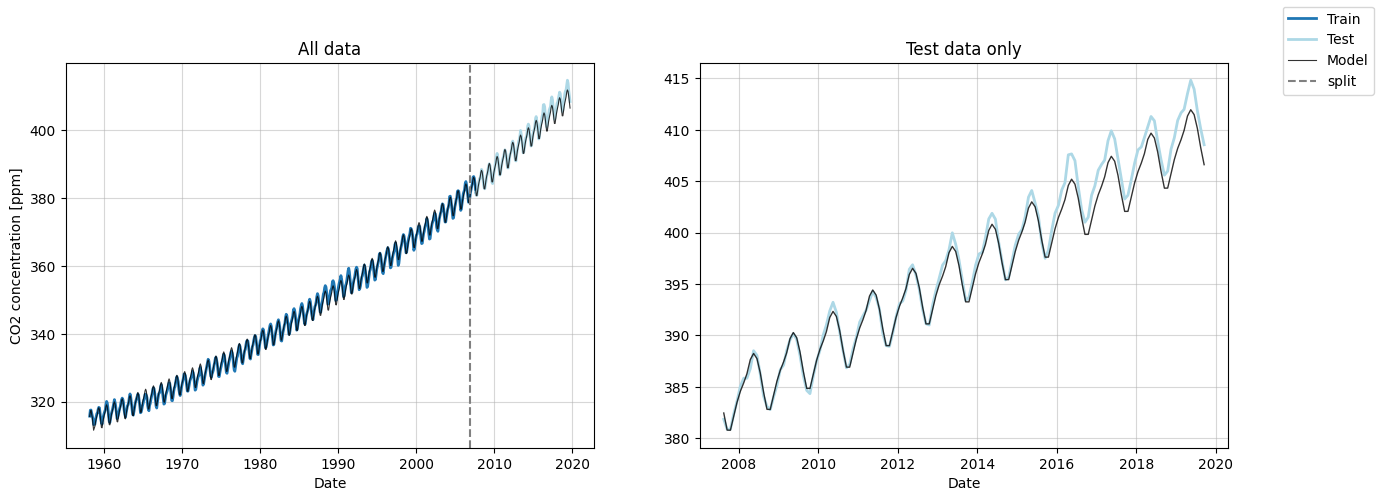

In [240]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(co2_data_filtered.iloc[0:n_split+2]['Date'], co2_data_filtered.iloc[0:n_split+2]['CO2 [ppm]'], linewidth=2, label='Train')
axes[0].plot(co2_data_test['Date'], co2_data_test['CO2 [ppm]'], c='lightblue', linewidth=2, label='Test')
axes[0].plot(co2_data_filtered['Date'], co2_data_filtered['Prediction'], alpha=0.8, c='black', linewidth=0.8, label='Model')
axes[0].grid(alpha=0.5)
x = co2_data_filtered[co2_data_filtered['Time'] == (n_split+0.5)/12]['Date']
axes[0].axvline(x=x, linestyle='--', c='gray', label='split')
axes[0].set_title('All data')
axes[1].plot(co2_data_test['Date'], co2_data_test['CO2 [ppm]'], c='lightblue', linewidth=2)
axes[1].plot(co2_data_test['Date'], co2_data_test['Prediction'], alpha=0.8, c='black', linewidth=1)
axes[1].grid(alpha=0.5)
axes[1].set_title('Test data only')
axes[0].set_ylabel('CO2 concentration [ppm]')
axes[0].set_xlabel('Date')
axes[1].set_xlabel('Date')
fig.legend()

In [222]:
mean_absolute_percentage_error(co2_data_test['CO2 [ppm]'], co2_data_test['Prediction'])

0.0020986895587367977

In [223]:
mean_squared_error(co2_data_test['CO2 [ppm]'], co2_data_test['Prediction'], squared=False)

1.1532682699222798

### Range of values

In [224]:
F_vals = quadratic_trend.predict(co2_data_train[['Time', 'Time2']])
F = F_vals.max() - F_vals.min()
F

69.1436923453914

In [225]:
P = periodic_part['Periodic'].max() - periodic_part['Periodic'].min()
P

6.292410667159608

In [226]:
co2_data_train['FinalResidual'] = co2_data_train['CO2 [ppm]'] - co2_data_train['Prediction']
R = co2_data_train['FinalResidual'].max() - co2_data_train['FinalResidual'].min()
R

3.836399237579542

In [227]:
print(F / P, P / R) 

10.988426535199878 1.640186611842205


In [228]:
co2_data_train

,Yr,Mn,Time,CO2 [ppm],Date,Time2,Time3,Residual,Periodic,Month,Prediction,FinalResidual
0,1958,03,0.208333,315.70,1958-03-15,0.043403,0.009042,1.431786,1.355569,Mar,315.623783,0.076217
1,1958,04,0.291667,317.45,1958-04-15,0.085069,0.024812,3.114440,2.561858,Apr,316.897418,0.552582
2,1958,05,0.375000,317.51,1958-05-15,0.140625,0.052734,3.106925,2.982891,May,317.385965,0.124035
3,1958,07,0.541667,315.86,1958-07-15,0.293403,0.158927,1.321391,0.776297,Jul,315.314906,0.545094
4,1958,08,0.625000,314.93,1958-08-15,0.390625,0.244141,0.323372,-1.301213,Aug,313.305416,1.624584
...,...,...,...,...,...,...,...,...,...,...,...,...
582,2007,02,49.125000,383.71,2007-02-15,2413.265625,118551.673828,0.963654,0.646407,Feb,383.392752,0.317248
583,2007,03,49.208333,384.34,2007-03-15,2421.460069,119156.014251,1.427517,1.355569,Mar,384.268053,0.071947
584,2007,04,49.291667,386.23,2007-04-15,2429.668403,119762.405020,3.151211,2.561858,Apr,385.640647,0.589353
585,2007,05,49.375000,386.41,2007-05-15,2437.890625,120370.849609,3.164736,2.982891,May,386.228154,0.181846


### Stationarity of a residual

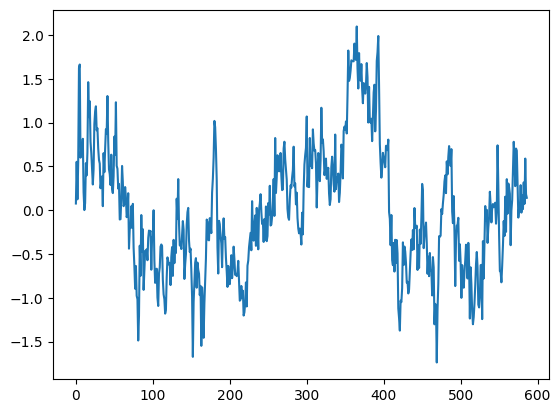

In [229]:
plt.plot(co2_data_train['FinalResidual'].reset_index(drop=True))

In [230]:
# ADF wrapper
def adf_test(timeseries):
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            'Test Statistic',
            'p-value',
            '#Lags Used',
            'Number of Observations Used',
        ],
    )
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

In [233]:
adf_test(co2_data_train['FinalResidual'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -2.942986
p-value                          0.040573
#Lags Used                      12.000000
Number of Observations Used    574.000000
Critical Value (1%)             -3.441794
Critical Value (5%)             -2.866588
Critical Value (10%)            -2.569459
dtype: float64


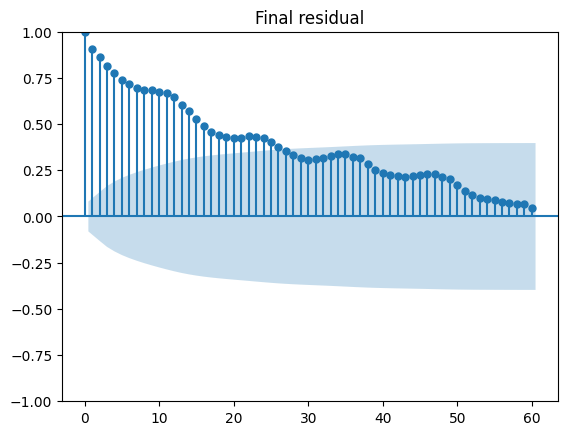

In [234]:
ax = plt.subplot()
sm.graphics.tsa.plot_acf(co2_data_train['FinalResidual'], lags=60, ax=ax, title='Final residual')
plt.show()